Based on https://github.com/MoritzThomasHuebner/QPOEstimation

In [ ]:
!pip install git+https://github.com/MoritzThomasHuebner/QPOEstimation.git
!pip install celerite
!pip install george

  Cloning https://github.com/MoritzThomasHuebner/QPOEstimation.git to /tmp/pip-req-build-r21uvfdp
  Running command git clone --filter=blob:none --quiet https://github.com/MoritzThomasHuebner/QPOEstimation.git /tmp/pip-req-build-r21uvfdp
  Resolved https://github.com/MoritzThomasHuebner/QPOEstimation.git to commit ba3a75fdff2a50e66fc5a007447457bb31317a59
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
  Created wheel for QPOEstimation: filename=QPOEstimation-0.2-py3-none-any.whl size=36685 sha256=11be3b00129c4a6f3cc42

In [ ]:
!apt-get install texlive-latex-base
!apt-get install texlive-font-utils texlive-fonts-extra
!apt-get install cm-super
!apt-get install dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-latex-base is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-font-utils is already the newest version (2021.20220204-1).
texlive-fonts-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  dvipng
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 78.9 kB of archives.
After this o

In [ ]:
%matplotlib inline

import os
from pathlib import Path
from scipy.signal import periodogram

import matplotlib
import matplotlib.pyplot as plt

import QPOEstimation
from QPOEstimation.get_data import *
from QPOEstimation.likelihood import get_kernel, get_mean_model, get_gp_likelihood
from QPOEstimation.prior import get_priors
from QPOEstimation.prior.gp import *
from QPOEstimation.utils import *

In [ ]:
data_source = "grb"
run_mode = "entire_segment"
start_time = 0
end_time = 1

In [ ]:
grb_id = "070220"
grb_label = ""
grb_binning = "1s"
grb_detector = "swift"
grb_energy_band = "all"

In [ ]:
polynomial_max = 2
amplitude_min = None
amplitude_max = None
offset_min = None
offset_max = None
sigma_min = None
sigma_max = None
t_0_min = None
t_0_max = None

min_log_a = None
max_log_a = None
min_log_c_red_noise = None
min_log_c_qpo = None
max_log_c_red_noise = None
max_log_c_qpo = None
minimum_window_spacing = 0

band_minimum = None
band_maximum = None

In [ ]:
recovery_mode = "qpo_plus_red_noise"
likelihood_model = "celerite"
background_model = "skew_gaussian"
n_components = 1
jitter_term = False
normalisation = False
offset = False

In [ ]:
sample = "rslice"
nlive = 1000

In [ ]:
try_load = False
resume = False

In [ ]:
suffix = f"_{n_components}_{background_model}s"
band = f"{band_minimum}_{band_maximum}Hz"
truths = None
recovery_mode_str = recovery_mode
if jitter_term:
    recovery_mode_str += "_jitter"

In [ ]:
times, y, yerr, outdir, label = get_data(
    data_source=data_source,
    run_mode=run_mode, recovery_mode=recovery_mode, recovery_mode_str=recovery_mode_str, likelihood_model=likelihood_model,
    grb_id=grb_id, grb_binning=grb_binning, grb_detector=grb_detector, grb_label=grb_label, grb_energy_band=grb_energy_band,
    start_time=start_time, end_time=end_time)
label += suffix

In [ ]:
if normalisation:
    y = (y - np.min(y))/(np.max(y) - np.min(y)) * 1
    yerr = yerr/(np.max(y) - np.min(y))


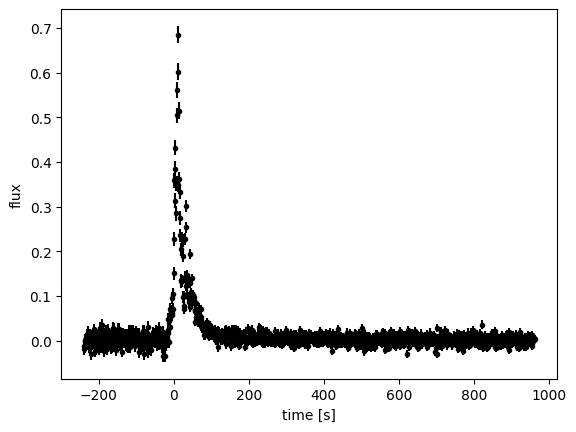

In [ ]:
plt.errorbar(times, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.xlabel("time [s]")
plt.ylabel("flux")
plt.show()

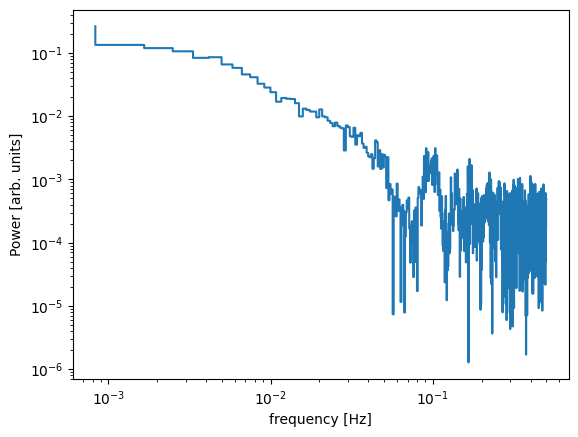

In [ ]:
fs = 1/(times[1] - times[0])
freqs, powers = periodogram(y, fs=fs, window="hann")
plt.loglog()
plt.step(freqs[1:], powers[1:])
plt.xlabel("frequency [Hz]")
plt.ylabel("Power [arb. units]")
plt.show()

In [ ]:
mean_prior_bound_dict = dict(
    amplitude_min=amplitude_min,
    amplitude_max=amplitude_max,
    offset_min=offset_min,
    offset_max=offset_max,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    t_0_min=t_0_min,
    t_0_max=t_0_max,
)

kernel_prior_bound_dict = dict(
    min_log_a=min_log_a, max_log_a=max_log_a,
    min_log_c_red_noise=min_log_c_red_noise,
    max_log_c_red_noise=max_log_c_red_noise,
    min_log_c_qpo=min_log_c_qpo,
    max_log_c_qpo=max_log_c_qpo,
    band_minimum=band_minimum,
    band_maximum=band_maximum,
)

priors = get_priors(
    times=times, y=y, yerr=yerr, likelihood_model=likelihood_model, kernel_type=recovery_mode,
    model_type=background_model, polynomial_max=polynomial_max, minimum_spacing=minimum_window_spacing,
    n_components=n_components, offset=offset, jitter_term=jitter_term,
    **kernel_prior_bound_dict, **mean_prior_bound_dict)

### Construct the mean model, kernel, and likelihood.

In [ ]:
mean_model = get_mean_model(
    model_type=background_model, n_components=n_components, y=y, offset=offset,
    likelihood_model=likelihood_model)
kernel = get_kernel(kernel_type=recovery_mode, jitter_term=jitter_term)
likelihood = get_gp_likelihood(mean_model=mean_model, kernel=kernel, times=times, y=y, yerr=yerr,
                               likelihood_model=likelihood_model)

### Store the `meta_data`

This information is stored in the result file and can be used to reconstruct the data and the model used in the inference process.

In [ ]:
meta_data = dict(
    kernel_type=recovery_mode, mean_model=background_model, times=times,
    y=y, yerr=yerr, likelihood_model=likelihood_model, truths=truths, n_components=n_components,
    offset=offset, jitter_term=jitter_term)

### Run the inference process

If `try_load = True`, try to load the result first. Otherwise, run the inference process using the usual `bilby` interface.

In [ ]:
result = None
if try_load:
    try:
        result = QPOEstimation.result.GPResult.from_json(outdir=f"{outdir}/results", label=label)
        result.outdir = f"{outdir}/results"
    except IOError:
        bilby.utils.logger.info("No result file found. Starting from scratch")
if result is None:
    Path(f"{outdir}/results").mkdir(parents=True, exist_ok=True)
    result = bilby.run_sampler(likelihood=likelihood, priors=priors, outdir=f"{outdir}/results",
                               label=label, sampler="dynesty", nlive=nlive, sample=sample,
                               resume=resume, result_class=QPOEstimation.result.GPResult,
                               meta_data=meta_data, save=True, gzip=False, nact=5, clean=True)

10:34 bilby INFO    : Running for label 'entire_segment_1_skew_gaussians', output will be saved to 'results/GRB070220_swift/entire_segment/qpo_plus_red_noise/celerite/results'
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
10:34 bilby INFO    : Analysis priors:
10:34 bilby INFO    : mean:t_0_0=Uniform(minimum=-359.288, maximum=1081.912, name='mean:t_0_0', latex_label='mean:t_0_0', unit=None, boundary=None)
10:34 bilby INFO    : mean:log_amplitude_0=Uniform(minimum=-2.6805866295895147, maximum=0.3151456439644761, name='ln A_0', latex_label='ln A_0', unit=None, boundary=None)
10:34 bilby INFO    : mean:log_sigma_rise_0=Uniform(minimum=-0.6931471805599453, maximum=7.784057002639929, name='ln sigma_rise_0', latex_label='ln sigma_rise_0', unit=None, boundary=None)
10:34 bilby INFO    : mean:log_sigma_fall_0=Uniform(minimum=-0.6931471805599453, maximum=7.784057002639

1it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
/usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
/usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
/usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterio

11:20 bilby INFO    : Summary of results:
nsamples: 5508
ln_noise_evidence:    nan
ln_evidence: 3178.634 +/-  0.225
ln_bayes_factor:    nan +/-  0.225



### Plotting functionalities

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

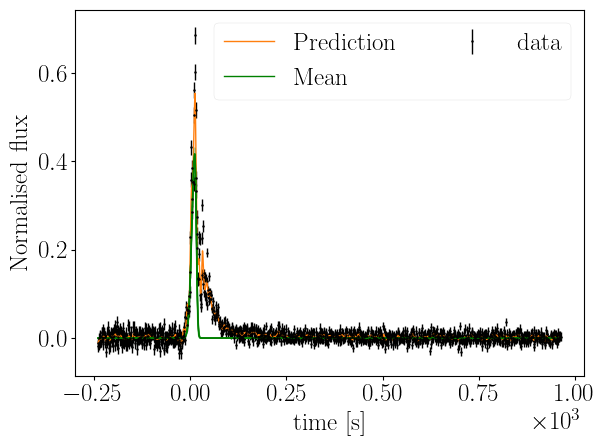

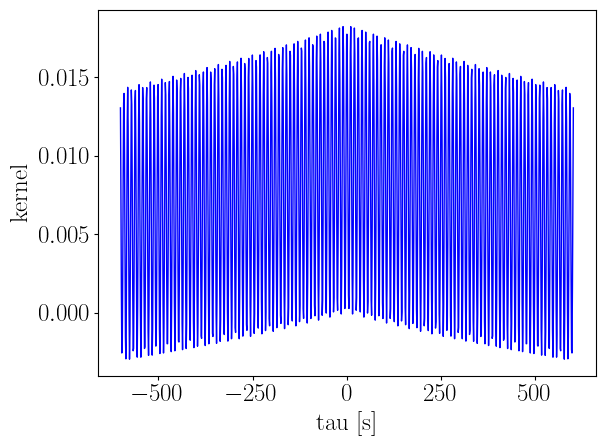

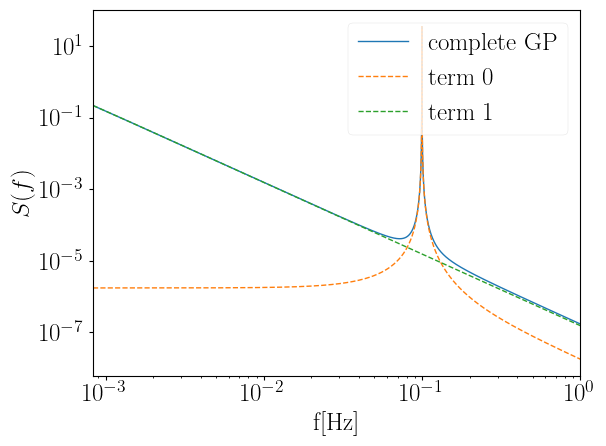

/usr/local/lib/python3.10/dist-packages/QPOEstimation/result.py:350: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(self.times, self.y - trend, yerr=self.yerr + jitter, fmt=".k", capsize=0, label="data", color="black")


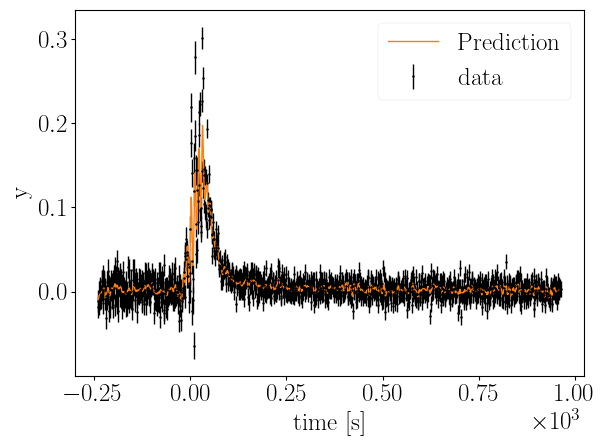

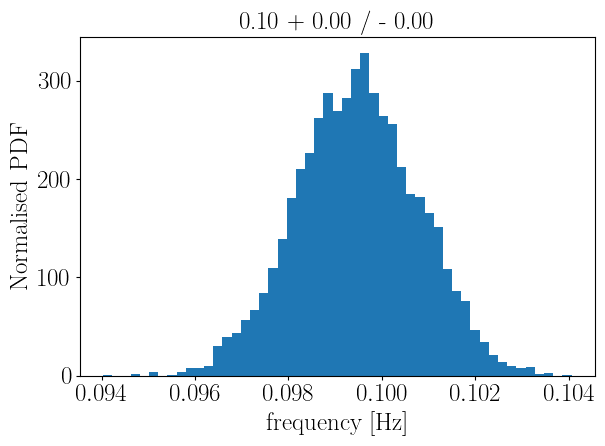

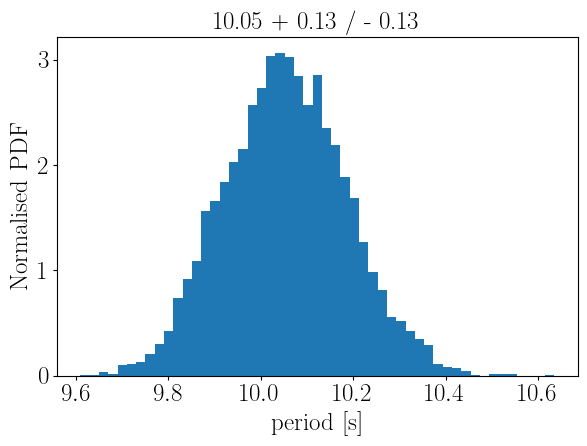

<Figure size 640x480 with 0 Axes>

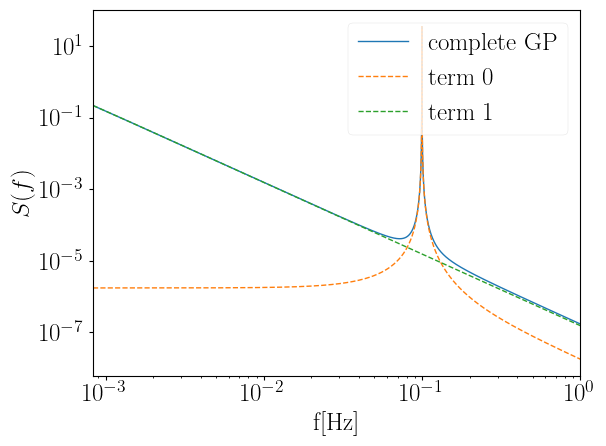

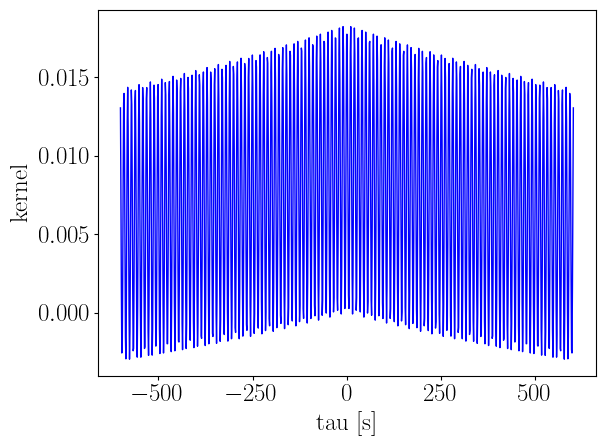

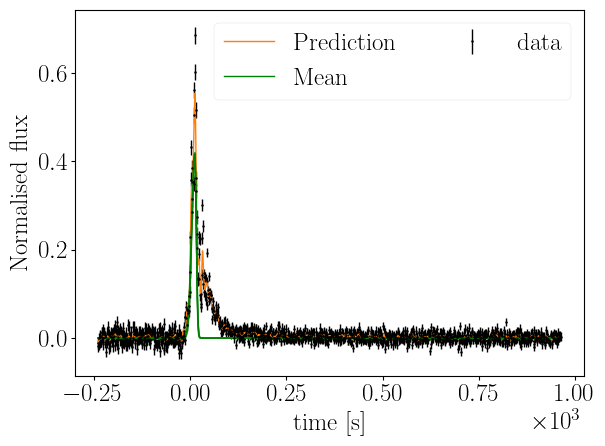

/usr/local/lib/python3.10/dist-packages/QPOEstimation/result.py:350: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(self.times, self.y - trend, yerr=self.yerr + jitter, fmt=".k", capsize=0, label="data", color="black")


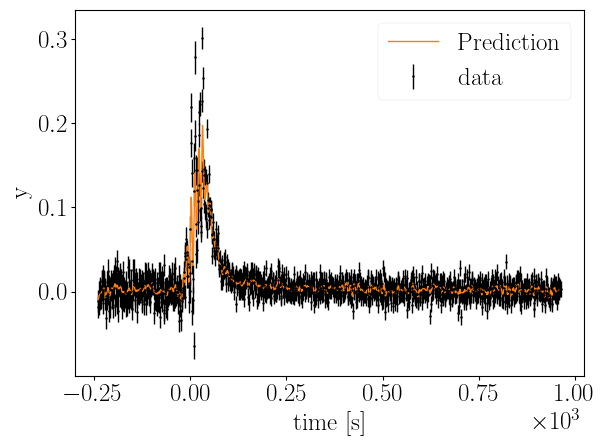

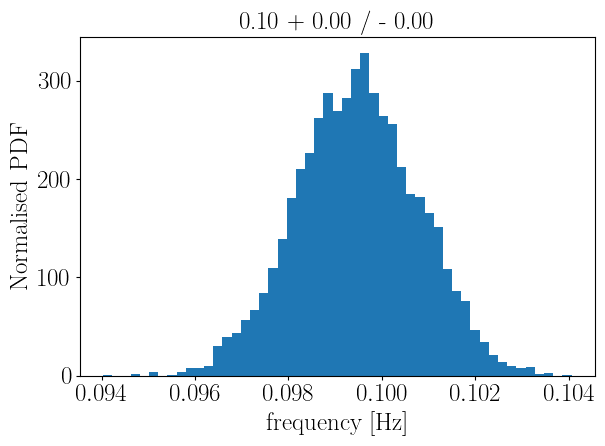

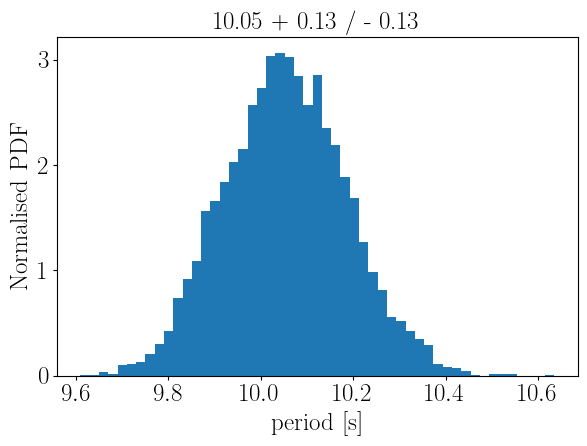

In [ ]:
result.plot_lightcurve()
result.plot_kernel()
result.plot_max_likelihood_psd()
result.plot_residual()
result.plot_frequency_posterior()
result.plot_period_posterior()
result.plot_duration_posterior()
result.plot_all(paper_style=True)

### Location of additional information

`bilby` stores some information of the run in the result file. We can access many of these as properties, for example the log evidence

In [ ]:
print(result.log_evidence)

3178.633548322186
